In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Define the base URL for the Census API (ACS 5-year estimates)
URL = "https://api.census.gov/data"

# Define your Census API Key (replace with your actual key)
api_key = "fbf85c344ae6d1e95862540efdd1b746ecfce696"

# Define the years we are interested in
years = [2020, 2021, 2022]

In [3]:
# Create an empty list to hold the data for each year
all_data = []

# Loop through each year to get the data for B08134_004E and B19013_001E
for year in years:
    params = {
        'get': 'NAME,B08134_004E,B19013_001E',  # B08134_004E = Work at home, B19013_001E = Median Household Income
        'for': 'state:*',  # Data for all states
        'key': api_key
    }

    # Send the request to the Census API for each year
    response = requests.get(f"{URL}/{year}/acs/acs5", params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()

        # Extract the column headers and rows of data
        columns = data[0]
        rows = data[1:]

        # Convert to DataFrame
        df = pd.DataFrame(rows, columns=columns)

        # Convert income and work-at-home data to numeric (if necessary) for analysis
        df['B19013_001E'] = pd.to_numeric(df['B19013_001E'], errors='coerce')  # Median Household Income
        df['B08134_004E'] = pd.to_numeric(df['B08134_004E'], errors='coerce')  # Work-at-home data

        # Add a column for the year to keep track of which year the data is from
        df['Year'] = year

        # Convert the state names to a more readable format if necessary
        df['State'] = df['NAME']

        # Drop the 'NAME' column as it's redundant now
        df = df.drop(columns=['NAME'])

        # Append the data for this year to the all_data list
        all_data.append(df)

    else:
        print(f"Error: {response.status_code} for year {year}")


   Home_Workers Group  Year  B19013_001E
0                 Low  2020      65304.0
1                 Low  2021      68002.0
2                 Low  2022      74014.0
3              Medium  2020      69110.0
4              Medium  2021      72724.0
5              Medium  2022      79325.0
6                High  2020      49640.0
7                High  2021      52452.0
8                High  2022      56969.5
9           Very High  2020      61939.5
10          Very High  2021      65799.5
11          Very High  2022      72052.0


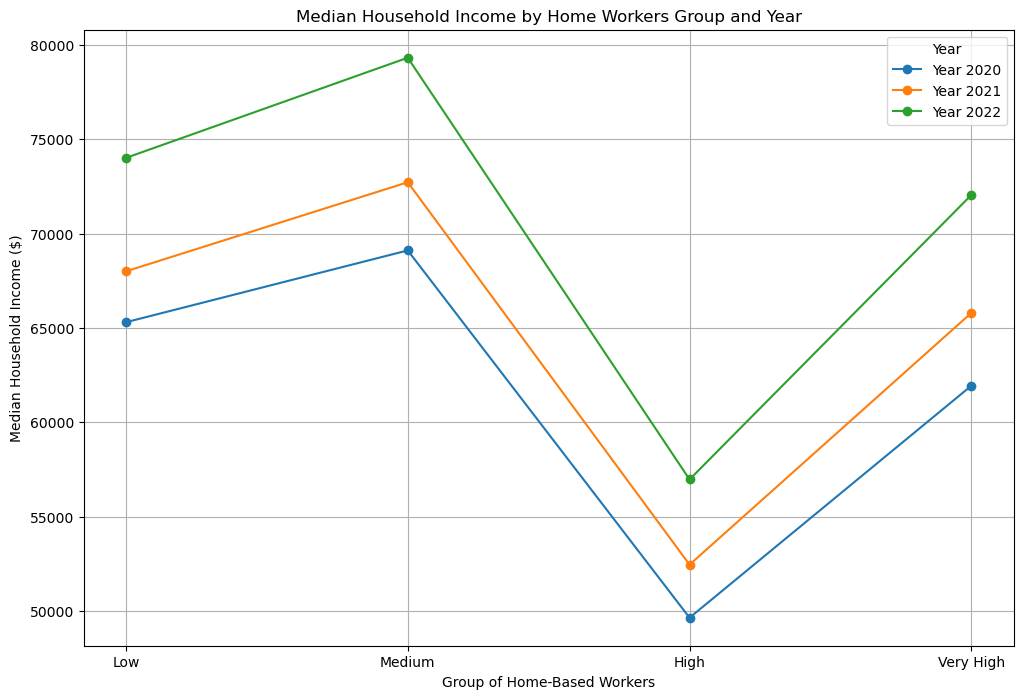

In [4]:
# Combine all data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Create income bins (for example, Low, Medium, High based on home-based workers)
bins = [0, 50000, 100000, 200000, float('inf')]  # You can adjust these ranges based on your data
labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column for the income group
final_df['Home_Workers Group'] = pd.cut(final_df['B08134_004E'], bins=bins, labels=labels)

# Group by the 'Home_Workers Group' and 'Year' to calculate the median household income for each group and each year
grouped_df = final_df.groupby(['Home_Workers Group', 'Year'], observed=False)['B19013_001E'].median().reset_index()

# Display the grouped data
print(grouped_df)

# Plot the data: Home-based worker groups vs Median Household Income by Year
plt.figure(figsize=(12, 8))
for year in years:
    year_data = grouped_df[grouped_df['Year'] == year]
    plt.plot(year_data['Home_Workers Group'], year_data['B19013_001E'], marker='o', label=f'Year {year}')

plt.title('Median Household Income by Home Workers Group and Year')
plt.xlabel('Group of Home-Based Workers')
plt.ylabel('Median Household Income ($)')
plt.legend(title="Year")
plt.grid(True)
plt.show()